### Imports

In [25]:
# !pip install ipywidgets

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import HDBSCAN
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import math
import os
import cv2
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

### Functions

#### Data transformation

In [27]:
def transform_mousecentric(df, main_dir, mouse):
    '''
    Transforms data into mouse-centric version.

    Parameters:
    df (pd.DataFrame): The input data.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.

    Returns:
    pd.DataFrame: Transformed data in mouse-centric version.
    '''
    
    folder_path = main_dir + "/Datasets/MouseCentric"
    file_path = f'/{mouse}_MouseCentric_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        mc_df = df.copy()
        mc_df = mc_df.iloc[:, 1:-1]
        mc_df = mc_df.astype(float)

        s1_x = mc_df.iloc[:,39].copy()
        s1_y = mc_df.iloc[:,40].copy()

        for column_index in range(0, len(mc_df.columns), 3):
            x_column = mc_df.columns[column_index]
            y_column = mc_df.columns[column_index+1]

            x = mc_df[x_column]
            y = mc_df[y_column]

            transformed_x = x - s1_x
            transformed_y = y - s1_y

            mc_df[x_column] = transformed_x
            mc_df[y_column] = transformed_y

        mc_df.iloc[:,39]=s1_x
        mc_df.iloc[:,40]=s1_y
        mc_df.insert(0, 'frame_number', df['frame_number'])
        mc_df['mouse_no'] = float(mouse)

        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mc_df.to_csv(folder_path + file_path, index=False)
        
    else:
        mc_df = pd.read_csv(folder_path + file_path)
        
    return mc_df
    
def transform_changecoord(df, main_dir, mouse):
    '''
    Transforms data into change coordinate version.

    Parameters:
    df (pd.DataFrame): The input data.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.

    Returns:
    pd.DataFrame: Transformed data in change coordinate version.
    '''
    folder_path = main_dir + "/Datasets/ChangeCoords"
    file_path = f'/{mouse}_ChangeCoords_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        cc_df = df.copy()
        cc_df = cc_df.iloc[:, 1:-1]
        cc_df = cc_df.astype(float)

        for column_index in range(0, len(cc_df.columns), 3):
            x_column = cc_df.columns[column_index]
            y_column = cc_df.columns[column_index+1]

            cc_df[x_column] = cc_df[x_column] - cc_df[x_column].shift(1)
            cc_df[y_column] = cc_df[y_column] - cc_df[y_column].shift(1)

            cc_df[x_column] = cc_df[x_column].fillna(0)
            cc_df[y_column] = cc_df[y_column].fillna(0)

        cc_df.insert(0, 'frame_number', df['frame_number'])
        cc_df['mouse_no'] = float(mouse)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        cc_df.to_csv(folder_path + file_path, index=False)
        
    else:
        cc_df = pd.read_csv(folder_path + file_path)
    return cc_df
    
def transform_mcpolar(mc_df, main_dir, mouse):
    '''
    Transforms data into mouse-centric polar coordinates version.

    Parameters:
    mc_df (pd.DataFrame): The input data in mouse-centric coordinates.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.

    Returns:
    pd.DataFrame: Transformed data in mouse-centric polar coordinates.
    '''
    folder_path = main_dir + "/Datasets/MouseCentricPolar"
    file_path = f'/{mouse}_MouseCentricPolar_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        mcp_df = mc_df.copy()
        mcp_df = mcp_df.iloc[:,1:-1]
        mcp_df = mcp_df.astype(float)

        for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):
            x = mcp_df[col_x]
            y = mcp_df[col_y]

            r = np.sqrt(x**2 + y**2)
            theta = np.arctan2(y, x)

            mcp_df[col_x] = r
            mcp_df[col_y] = theta

        mcp_df.insert(0, 'frame_number', df['frame_number'])
        mcp_df['mouse_no'] = float(mouse)
        
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mcp_df.to_csv(folder_path + file_path, index=False)
    
    else:
        mcp_df = pd.read_csv(folder_path + file_path)
    
    return mcp_df
    
def transform_mcdirectional(mc_df, mcp_df, main_dir, mouse):
    '''
    Transforms data into mouse-centric directional coordinates version.

    Parameters:
    mc_df (pd.DataFrame): The input data in mouse-centric coordinates.
    mcp_df (pd.DataFrame): The data in mouse-centric polar coordinates for reference.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.

    Returns:
    pd.DataFrame: Transformed data in mouse-centric directional coordinates.
    '''
    folder_path = main_dir + "/Datasets/MouseDirectional"
    file_path = f'/{mouse}MouseDirectional_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        md_df = mc_df.copy()
        md_df = md_df.iloc[:,1:-1]
        md_df = md_df.astype(float)

        coordinates_columns = [col for col in md_df.columns if 'x' in col or 'y' in col]

        for frame_number, frame_data_polar in mcp_df.groupby('frame_number'):

            rotation_angle = frame_data_polar.at[frame_data_polar.index[0], "('S2', 'y')"]
            affine_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                      [np.sin(rotation_angle), np.cos(rotation_angle)]])

            for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):

                x = md_df[col_x]
                y = md_df[col_y]

                points = np.column_stack((x, y))
                transformed_points = np.dot(points[frame_number], affine_matrix)

                md_df.at[frame_number, col_x] = transformed_points[0]
                md_df.at[frame_number, col_y] = transformed_points[1]

        md_df.insert(0, 'frame_number', mc_df['frame_number'])
        md_df['mouse_no'] = float(mouse)
        
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        md_df.to_csv(folder_path + file_path, index=False)
    
    else:
        md_df = pd.read_csv(folder_path + file_path)
    
    return md_df

def transform_mcdirectionalpolar(md_df, main_dir, mouse):
    '''
    Transforms data into mouse-centric directional polar coordinates version.

    Parameters:
    md_df (pd.DataFrame): The input data in mouse-centric directional coordinates.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.

    Returns:
    pd.DataFrame: Transformed data in mouse-centric directional polar coordinates.
    '''
    folder_path = main_dir + "/Datasets/MouseDirectionalPolar"
    file_path = f'/{mouse}MouseDirectionalPolar_data.csv'
    if not os.path.exists(folder_path + file_path):
        
        mdp_df = md_df.copy()
        mdp_df = mdp_df.iloc[:,1:-1]
        mdp_df = mdp_df.astype(float)
        
        coordinates_columns = [col for col in md_df.columns if 'x' in col or 'y' in col]
        
        for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):
            x = mdp_df[col_x]
            y = mdp_df[col_y]
            
            r = np.sqrt(x**2, y**2)
            theta = np.arctan2(y, x)
            
            mdp_df[col_x] = r
            mdp_df[col_y] = theta
            
        mdp_df.insert(0, 'frame_number', df['frame_number'])
        mdp_df['mouse_no'] = float(mouse)
        
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mdp_df.to_csv(folder_path + file_path, index=False)
    
    else:
        mdp_df = pd.read_csv(folder_path + file_path)
    
    return mdp_df

def create_dataset(main_dir: str, datatype: str):
    '''
    Create data files with the given transformation type from the original data in the given main directory.

    Parameters:
    main_dir (str): The main directory containing the original data and transformation results.
    datatype (str): The type of data transformation to apply.

    Returns:
    pd.DataFrame: The dataset created based on the specified data transformation.

    Supported 'datatype' values:
    - "Original": Original data.
    - "MouseCentric": Mouse-centric data.
    - "MouseCentricPolar": Mouse-centric polar data.
    - "ChangeCoord": Data with changed coordinates.
    - "MouseDirectional": Mouse-centric directional data.
    - "MouseDirectionalPolar": Mouse-centric directional polar data.
    '''
    folder_path = main_dir + "/Datasets/Original"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    dataframes = []
    
    filtered_dir = os.path.join(main_dir, 'filtered')
    files = os.listdir(filtered_dir)
    
    for file in tqdm(files, desc="Processing Files"):
        mouse=file.split("_")[1]+"."+file.split("_")[2][0:-3]
        file=os.path.join(main_dir+'/filtered/', file)
        
        new_file_path = f'/{mouse}_Original_data.csv'
        if not os.path.exists(folder_path + new_file_path):
            df = pd.read_csv(file,header=[1,2])
            df.columns = ['frame_number'] + list(df.columns[1:])
            df['mouse_no'] = float(mouse)
            df.to_csv(folder_path + new_file_path, index=False)
        else:
            df = pd.read_csv(folder_path + new_file_path)

        if datatype == "Original":
            dataframes.append(df)
        elif datatype == "MouseCentric":
            mc_df = transform_mousecentric(df, main_dir, mouse)
            dataframes.append(mc_df)
        elif datatype == "MouseCentricPolar":
            mc_df = transform_mousecentric(df, main_dir, mouse)
            mcp_df = transform_mcpolar(mc_df, main_dir, mouse)
            dataframes.append(mcp_df)
        elif datatype == "ChangeCoord":
            cc_df = transform_changecoord(df, main_dir, mouse)
            dataframes.append(cc_df)
        elif datatype == "MouseDirectional":
            mc_df = transform_mousecentric(df, main_dir, mouse)
            mcp_df = transform_mcpolar(mc_df, main_dir, mouse)
            mcd_df = transform_mcdirectional(mc_df, mcp_df, main_dir, mouse)
            dataframes.append(mcd_df)
        elif datatype == "MouseDirectionalPolar":
            mc_df = transform_mousecentric(df, main_dir, mouse)
            mcp_df = transform_mcpolar(mc_df, main_dir, mouse)
            md_df = transform_mcdirectional(mc_df, mcp_df, main_dir, mouse)
            mdp_df = transform_mcdirectionalpolar(md_df, main_dir, mouse)
            dataframes.append(mdp_df)
    
    dataset = pd.concat(dataframes, ignore_index=True)
    
    return dataset

#### Selecting subset from data

In [28]:
def generate_sub_dataset(dataset, frames_per_video=11250, mouse_number=None):
    """
    Generate a sub-dataset by selecting random videos or videos from a specific mouse
    from the given dataset.

    Args:
    dataset (pd.DataFrame): The original dataset.
    num_videos (int or None): The number of random videos to select. Set to None if specifying a mouse.
    frames_per_video (int): The number of frames per video.
    mouse_number (int or None): The mouse number to select videos for. Set to None for random selection.

    Returns:
    pd.DataFrame: A sub-dataset containing the selected videos.
    """
    if mouse_number is not None:
        # Select videos for a specific mouse
        sub_dataset = dataset[dataset['mouse_no'] == mouse_number]
        print(f'The data for mouse {mouse_number} was extracted.')
        return sub_dataset.reset_index(drop=True)
    else:
        # Generate random video indices
        selected_video_indices = np.random.choice(range(1, 99), size=1, replace=False)

    selected_videos = []

    # Create slices for each selected video
    for video_index in selected_video_indices:
        # Calculate the starting and ending frame indices for the video
        start_frame = video_index * frames_per_video
        end_frame = (video_index + 1) * frames_per_video
        # Use .loc to create a slice by row index
        video_slice = dataset.loc[start_frame:end_frame - 1]
        selected_videos.append(video_slice)

    # Concatenate the selected videos to create a sub-dataset
    sub_dataset = pd.concat(selected_videos, ignore_index=True)
    print("The following mice were randomly selected: "+ " ".join(map(str, sub_dataset['mouse_no'].unique())))
    return sub_dataset


#### UMAP and visualisation

In [29]:
def visualize_umap(data, n_neighbors=15, min_dist=0.1, n_components=2):
    '''
    Visualize data using UMAP with adjustable hyperparameters.

    Parameters:
    data (pd.DataFrame): The data to visualize.
    n_neighbors (int): The number of neighbors for UMAP.
    min_dist (float): The minimum distance between points in UMAP.
    n_components (int): The number of UMAP dimensions to reduce to (2 or 3).

    Returns:
    None
    '''
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    umap_result = umap_model.fit_transform(data.iloc[:, 1:-1])
    
    if n_components == 2:
        # 2D plot
        plt.figure(figsize=(8, 6))
        plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.1)
        plt.title("UMAP 2D Visualization")
        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.show()
    elif n_components == 3:
        # 3D plot
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(121, projection='3d')  # 3D plot
        ax.scatter(umap_result[:, 0], umap_result[:, 1], umap_result[:, 2], alpha=0.1)
        ax.set_title("UMAP 3D Visualization")
        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        ax.set_zlabel("UMAP Dimension 3")

        # 2D plot of first 2 dimensions
        ax2 = fig.add_subplot(122)
        ax2.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.1)
        ax2.set_title("UMAP 2D Visualization (1st and 2nd dimensions)")
        ax2.set_xlabel("UMAP Dimension 1")
        ax2.set_ylabel("UMAP Dimension 2")
        plt.show()
    
    return umap_result

#### HDBSCAN and visualisation

In [30]:
def cluster_and_visualize_umap(umap_result, min_samples=4, min_cluster_size=4):
    '''
    Cluster UMAP data using HDBSCAN from scikit-learn and visualize the results.

    Parameters:
    umap_result (ndarray): The UMAP data to cluster and visualize.
    min_samples (int): The minimum number of samples in a neighborhood for HDBSCAN.
    min_cluster_size (int): The minimum number of samples in a cluster for HDBSCAN.

    Returns:
    None
    '''
    # Create an HDBSCAN clusterer with optional parameters
    clusterer = HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    
    # Fit the clusterer to the UMAP data
    cluster_labels = clusterer.fit_predict(umap_result)
    
    # Extract cluster labels
    cluster_labels = clusterer.labels_
    
    # Number of clusters found (excluding noise points)
    num_clusters = len(np.unique(cluster_labels[cluster_labels != -1]))
    
    # Display the number of clusters
    print(f"Number of clusters: {num_clusters}")
    
    if umap_result.shape[1] == 2:
        # 2D plot
        plt.figure(figsize=(8, 6))
        
        # Extract unique cluster labels (excluding noise points)
        unique_clusters = np.unique(cluster_labels[cluster_labels != -1])
        
        # Assign different colors to clusters
        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))
        
        for cluster_label, color in zip(unique_clusters, colors):
            cluster_indices = np.where(cluster_labels == cluster_label)
            plt.scatter(
                umap_result[cluster_indices, 0], 
                umap_result[cluster_indices, 1], 
                c=[color], 
                s=50,
                alpha=0.7
            )
        
        # Add labels and title
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.title('HDBSCAN Clustering Results in 2D')
        
        plt.grid(True)
        plt.show()
    elif umap_result.shape[1] == 3:
        # 3D plot
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121, projection='3d')
        
        # Extract unique cluster labels (excluding noise points)
        unique_clusters = np.unique(cluster_labels[cluster_labels != -1])
        
        # Assign different colors to clusters
        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))
        
        for cluster_label, color in zip(unique_clusters, colors):
            cluster_indices = np.where(cluster_labels == cluster_label)
            ax.scatter(
                umap_result[cluster_indices, 0], 
                umap_result[cluster_indices, 1], 
                umap_result[cluster_indices, 2], 
                c=[color], 
                s=50,
                alpha=0.7
            )
        
        # Add labels and title
        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')
        ax.set_zlabel('UMAP Dimension 3')
        ax.set_title('HDBSCAN Clustering Results in 3D')
        
        ax2 = fig.add_subplot(122)
        for cluster_label, color in zip(unique_clusters, colors):
            cluster_indices = np.where(cluster_labels == cluster_label)
            ax2.scatter(umap_result[cluster_indices, 0], umap_result[cluster_indices, 1], label=f'Cluster {cluster_label}', c=[color], s=50)
        
        ax2.set_xlabel('UMAP Dimension1')
        ax2.set_ylabel('UMAP Dimension2')
        ax2.set_title('HDBSCAN Clustering Results in 2D')
        
        plt.tight_layout()
        plt.show()
        
    return clusterer

In [31]:
def plot_top_hdbscan_clusters(clusterer, umap_data, num_clusters_to_plot=5):
    '''
    Plot the top N largest clusters (excluding noise points) using HDBSCAN results.

    Parameters:
    clusterer: HDBSCAN clusterer.
    umap_data (ndarray): The UMAP data to visualize.
    num_clusters_to_plot (int): The number of largest clusters to plot.

    Returns:
    None
    '''
    cluster_labels = clusterer.labels_
    
    if umap_data.shape[1] == 2:
        # 2D plot
        plt.figure(figsize=(8, 6))
        
        # Get the cluster labels for the top N largest clusters (excluding noise points)
        unique_clusters, cluster_sizes = np.unique(cluster_labels, return_counts=True)
        cluster_info = list(zip(unique_clusters, cluster_sizes))
        sorted_clusters = sorted(cluster_info, key=lambda x: x[1], reverse=True)
        top_clusters = [label for label, size in sorted_clusters if label != -1][:num_clusters_to_plot]
        
        # Assign different colors to clusters
        colors = plt.cm.Spectral(np.linspace(0, 1, len(top_clusters)))
        
        for cluster_label, color in zip(top_clusters, colors):
            cluster_indices = np.where(cluster_labels == cluster_label)
            plt.scatter(
                umap_data[cluster_indices, 0],
                umap_data[cluster_indices, 1],
                label=f'Cluster {cluster_label}',
                c=[color],
                s=50,
                alpha=0.7
            )
        
        # Add labels and title
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.title(f'Top {num_clusters_to_plot} Largest Clusters (Excluding Noise) in 2D')
        
        plt.grid(True)
        plt.show()
    elif umap_data.shape[1] == 3:
        # 3D plot
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121, projection='3d')
        
        # Get the cluster labels for the top N largest clusters (excluding noise points)
        unique_clusters, cluster_sizes = np.unique(cluster_labels, return_counts=True)
        cluster_info = list(zip(unique_clusters, cluster_sizes))
        sorted_clusters = sorted(cluster_info, key=lambda x: x[1], reverse=True)
        top_clusters = [label for label, size in sorted_clusters if label != -1][:num_clusters_to_plot]
        
        # Assign different colors to clusters
        colors = plt.cm.Spectral(np.linspace(0, 1, len(top_clusters)))
        
        for cluster_label, color in zip(top_clusters, colors):
            cluster_indices = np.where(cluster_labels == cluster_label)
            ax.scatter(
                umap_data[cluster_indices, 0],
                umap_data[cluster_indices, 1],
                umap_data[cluster_indices, 2],
                label=f'Cluster {cluster_label}',
                c=[color],
                s=50,
                alpha=0.7
            )
        
        # Add labels and title
        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')
        ax.set_zlabel('UMAP Dimension 3')
        ax.set_title(f'Top {num_clusters_to_plot} Largest Clusters (Excluding Noise) in 3D')
        
        ax2 = fig.add_subplot(122)
        for cluster_label, color in zip(top_clusters, colors):
            cluster_indices = np.where(cluster_labels == cluster_label)
            ax2.scatter(umap_data[cluster_indices, 0], umap_data[cluster_indices, 1], label=f'Cluster {cluster_label}', c=[color], s=50)
        
        ax2.set_xlabel('UMAP Dimension 1')
        ax2.set_ylabel('UMAP Dimension 2')
        ax2.set_title(f'Top {num_clusters_to_plot} Largest Clusters in 2D (Dimension 1 & 2)')
        
        plt.tight_layout()
        plt.legend()
        plt.show()
        
    return top_clusters

In [32]:
def save_frames_for_clusters_by_mouse(input_video_directory, output_directory, frame_data):
    '''
    Save frames from videos for clusters grouped by the mouse numbers.

    Parameters:
    input_video_directory (str): Directory containing video files.
    output_directory (str): Directory where frames will be saved.
    frame_data (pd.DataFrame): DataFrame containing frame data, including 'frame_number', 'cluster_label', and 'mouse_no'.

    Returns:
    None
    '''
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)
    
    # Get the 10 largest clusters

    # Group frame data by mouse number
    grouped_data = frame_data.groupby('mouse_no')

    # Loop through each mouse number and corresponding cluster data
    for mouse_number, mouse_data in grouped_data:
        # Extract the mouse-specific video file
        
        video_filename = f"Animal {str(mouse_number).replace('.', '_')}DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4"
        video_path = os.path.join(input_video_directory, video_filename)

        # Open the video file
        cap = cv2.VideoCapture(video_path)

        # Create a subdirectory for the current mouse
        mouse_output_directory = os.path.join(output_directory, f"mouse_{mouse_number}")
        os.makedirs(mouse_output_directory, exist_ok=True)

        # Loop through the frame data for the current mouse
        for _, frame_info in mouse_data.iterrows():
            frame_number = int(frame_info['frame_number'])
            cluster_label = frame_info[cluster_column]

            # Set the video frame to the specified frame number
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)
            ret, frame = cap.read()

            if ret:
                # Save the frame with the cluster label and mouse number
                frame_filename = os.path.join(mouse_output_directory, f"frame_cluster{cluster_label}_mouse{mouse_number}_frame{frame_number}.png")
                cv2.imwrite(frame_filename, frame)

        # Release the video capture object for the current mouse
        cap.release()

In [33]:
def save_frames_for_clusters(input_video_path, output_directory, largest_clusters, frame_data, datatype, n_components):
    '''
    Save frames from the input video for the specified clusters.

    Parameters:
    input_video_path (str): Path to the input video file.
    output_directory (str): Directory where frames will be saved.
    largest_clusters (list): List of cluster labels for which frames should be saved.
    frame_data (pd.DataFrame): DataFrame containing frame data including 'frame_number' and 'cluster_label'.
    datatype (str): The type of data used
    n_components (int): Indicates how many dimensions UMAP has reduced the data to

    Returns:
    None
    '''
    # Extract the mouse number from the data
    mouse_no = subset['mouse_no'].unique().item()
    
    # Set the output to a subfolder for this mouse
    mouse_dir = output_directory + f"/clustered_{datatype}_data_{n_components}-dimensional_mouse_nr_{str(mouse_no)}"
    
    # Create the output directory if it doesn't exist
    os.makedirs(mouse_dir, exist_ok=True)
    
    # Open the input video using OpenCV
    video_filename = f"/Animal_{str(mouse_no).replace('.', '_')}DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4"
    video_path = input_video_path + video_filename
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")

    # Iterate through the specified clusters
    for cluster_label in largest_clusters:
        # Create a subdirectory for each cluster
        cluster_dir = os.path.join(mouse_dir, f'cluster_{cluster_label}')
        os.makedirs(cluster_dir, exist_ok=True)

        # Filter data points for the current cluster
        cluster_data = frame_data[frame_data['cluster_label'] == cluster_label]

        # Loop through the frame numbers in the cluster and save frames
        for _, row in cluster_data.iterrows():
            frame_number = int(row['frame_number'])
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)
            ret, frame = cap.read()
            if ret:
                frame_filename = os.path.join(cluster_dir, f'frame_{frame_number}.png')
                cv2.imwrite(frame_filename, frame)

    # Release the video capture object
    cap.release()

## Start here

### Loading the data

In [34]:
def plot_timeline_for_largest_clusters(data, largest_clusters):
    '''
    Generate a timeline for the largest clusters (excluding noise) in the given data.

    Parameters:
    data (pd.DataFrame): DataFrame containing frame data, including 'frame_number' and 'cluster_label'.
    num_clusters_to_plot (int): Number of largest clusters to include in the timeline.

    Returns:
    None
    '''
    # Filter data to exclude noise cluster (-1)
    filtered_data = data[data['cluster_label'] != -1]
    
    # Extract the number of plots from the given largest clusters
    num_clusters_to_plot = len(largest_clusters)
    
    # Create a figure with subplots for each of the largest clusters
    num_rows = (num_clusters_to_plot + 1) // 2  # Calculate the number of rows for subplots
    fig, axs = plt.subplots(num_rows, 2, figsize=(12, 12))
    fig.suptitle(f'Timeline of the {num_clusters_to_plot} Largest Clusters (Excluding Noise)', fontsize=16)

    # Plot colored indicators for each of the largest clusters
    for idx, cluster_label in enumerate(largest_clusters):
        cluster_indices = filtered_data[filtered_data['cluster_label'] == cluster_label]
        frame_numbers = cluster_indices['frame_number'].values
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]
        ax.set_title(f'Cluster {cluster_label}')
        ax.set_xlabel('Frame Number')
        ax.set_yticks([])
        for frame_number in frame_numbers:
            ax.axvspan(frame_number, frame_number, alpha=0.5, color=f'C{idx}')

    # Hide empty subplots
    for idx in range(num_clusters_to_plot, num_rows * 2):
        row = idx // 2
        col = idx % 2
        axs[row, col].axis('off')

    # Adjust layout and spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Display the timeline
    plt.show()

Set a source directory below as `main_folder`

In [35]:
# Set the main folder to work from. This folder should have a subfolder called 'filtered' with all the unedited mouse csv files. 
# The newly transformed data will then be put in corresponding subfolders in this main folder.
main_folder = "C:/Users/Kieran/Documents/Master Thesis Data"

data_options = ["Original", "MouseCentric", "MouseCentricPolar", "ChangeCoord", "MouseDirectional", "MouseDirectionalPolar"]

dropdown = widgets.Dropdown(options=data_options, description='Select a data type:')
display(dropdown)

Dropdown(description='Select a data type:', options=('Original', 'MouseCentric', 'MouseCentricPolar', 'ChangeC…

**Make sure to run all cells above this** \
Select a datatype from the selection box above. Running the cell below will result in generating/transforming that data
and will display it underneath.

In [39]:
datatype = dropdown.value
dataset = create_dataset(main_folder, datatype)
dataset

Processing Files: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.12it/s]


,frame_number,"('nose', 'x')","('nose', 'y')","('nose', 'likelihood')","('H1R', 'x')","('H1R', 'y')","('H1R', 'likelihood')","('H2R', 'x')","('H2R', 'y')","('H2R', 'likelihood')",...,"('tail', 'x')","('tail', 'y')","('tail', 'likelihood')","('S2', 'x')","('S2', 'y')","('S2', 'likelihood')","('S1', 'x')","('S1', 'y')","('S1', 'likelihood')",mouse_no
0,0,0.000000,0.000000,0.999969,0.000000,0.000000,0.999760,0.000000,0.000000,0.996968,...,0.000000,0.000000,0.998689,0.000000,0.000000,0.994912,0.000000,0.000000,0.995648,11.4
1,1,0.444275,2.021118,0.999950,0.536194,1.981354,0.999568,4.448181,4.355835,0.997916,...,1.670120,0.212906,0.999059,0.595001,0.076477,0.996069,3.630341,2.596069,0.993003,11.4
2,2,0.439880,3.892548,0.999945,0.945496,3.524902,0.999638,1.928741,0.726379,0.999153,...,0.798141,1.392517,0.999419,2.681183,0.000000,0.986211,3.590607,2.148987,0.987800,11.4
3,3,7.703064,0.000000,0.999765,5.919373,0.000000,0.999534,4.751312,0.000000,0.999468,...,1.855469,1.921738,0.999285,2.977997,0.041992,0.981083,3.765533,2.638062,0.994152,11.4
4,4,17.169312,0.000000,0.999855,20.999176,0.000000,0.999252,17.283508,0.000000,0.998945,...,0.000000,4.927261,0.999156,0.000000,0.000000,0.983985,1.823181,0.067993,0.995609,11.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102495,11245,1.339661,2.253326,0.999232,3.207214,5.388489,0.999924,3.782471,2.128571,0.999492,...,0.582886,0.000000,0.999563,0.424469,0.375305,0.998793,4.226929,0.000000,0.998882,88.3
1102496,11246,1.342590,4.823639,0.999680,1.945129,3.831635,0.999842,0.461548,1.584595,0.999562,...,0.348389,0.000000,0.999529,0.385101,0.000000,0.998716,0.232422,-0.049561,0.998840,88.3
1102497,11247,12.412659,0.000000,0.999622,9.379395,0.000000,0.999950,6.598083,2.645782,0.999656,...,-0.155914,-1.260956,0.999215,0.496552,-0.301575,0.999035,0.308044,0.000000,0.998980,88.3
1102498,11248,0.000000,0.000000,0.999570,0.000000,0.000000,0.999939,0.000000,0.000000,0.999616,...,0.000000,-0.214752,0.999225,0.000000,-0.073730,0.998865,0.000000,0.000000,0.998603,88.3


#### Extracting subset from the data

Use the cell below to select a subset from the data. \
You can specify a specific mouse number to get only the frames from that video, or choose to extract a random
video from the data.

In [40]:
mouse_number = None # Change this to a specific mouse number to extract that data. Set to None when extracting random videos.

subset = generate_sub_dataset(dataset, mouse_number = mouse_number)
subset

The following mice were randomly selected: 154.4


,frame_number,"('nose', 'x')","('nose', 'y')","('nose', 'likelihood')","('H1R', 'x')","('H1R', 'y')","('H1R', 'likelihood')","('H2R', 'x')","('H2R', 'y')","('H2R', 'likelihood')",...,"('tail', 'x')","('tail', 'y')","('tail', 'likelihood')","('S2', 'x')","('S2', 'y')","('S2', 'likelihood')","('S1', 'x')","('S1', 'y')","('S1', 'likelihood')",mouse_no
0,0,0.000000,0.000000,0.999795,0.000000,0.000000,0.999906,0.000000,0.000000,0.999778,...,0.000000,0.000000,0.936093,0.000000,0.000000,0.999863,0.000000,0.000000,0.998598,154.4
1,1,4.015808,14.132629,0.999808,0.000000,11.168915,0.999952,0.000000,6.679504,0.999834,...,0.140167,0.249237,0.936288,0.000000,1.311066,0.999812,0.000000,0.280090,0.999230,154.4
2,2,0.185493,0.251556,0.999780,0.000000,0.590363,0.999953,0.000000,0.201080,0.999870,...,0.000000,0.301559,0.926110,0.000000,2.011017,0.999709,0.000000,0.242737,0.999242,154.4
3,3,0.931923,10.038544,0.999881,-1.741257,7.510803,0.999876,-1.736969,6.457153,0.999827,...,-0.140167,0.842270,0.887408,-1.368042,0.131653,0.999755,-2.421021,1.084534,0.999640,154.4
4,4,0.030685,4.508759,0.999911,0.000000,6.178986,0.999827,0.000000,3.766235,0.999898,...,-0.131866,0.000000,0.927962,-0.991852,0.000000,0.999560,0.000000,2.074280,0.999826,154.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,11245,-2.157532,0.000000,0.998415,-3.840912,1.110474,0.999940,-2.275970,3.713165,0.999523,...,0.000000,-2.767731,0.999959,6.059540,-0.107666,0.969382,0.000000,1.521271,0.986533,154.4
11246,11246,-5.484833,0.945251,0.999495,-3.721344,1.111633,0.999853,-4.500305,3.275787,0.999556,...,0.000000,-0.286591,0.999954,4.489563,-0.215698,0.969171,0.748016,3.826874,0.992879,154.4
11247,11247,-7.734314,1.279236,0.993844,-6.681183,1.503601,0.999273,-8.659241,0.280579,0.999644,...,3.533096,-0.299530,0.999963,10.029343,0.000000,0.980059,0.000000,5.138000,0.964204,154.4
11248,11248,-2.115631,0.000000,0.993183,-0.529480,0.000000,0.999492,-0.600067,0.000000,0.999667,...,0.000000,-0.335846,0.999962,0.000000,0.000000,0.980490,0.000000,0.000000,0.964589,154.4


### Analysing the data

#### Dimensionality reduction with UMAP
The following function will apply UMAP dimensionality reduction on the data. \
The hyperparameters can be adjusted as desired.

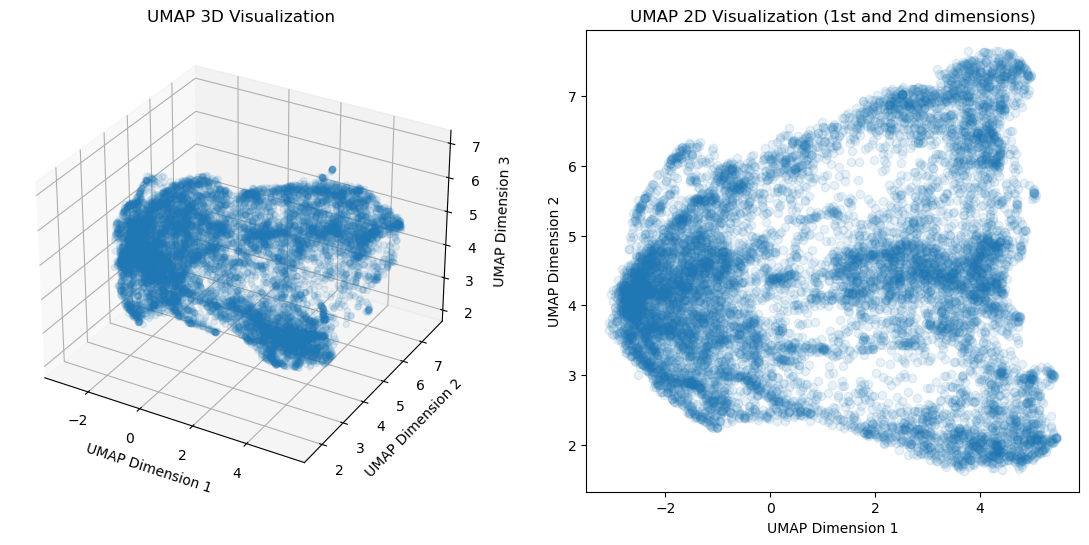

In [41]:
n_neighbors  = 15
min_dist     = 0.1
n_components = 3 # Set this to either 2 or 3 to create 2D or 3D UMAP and cluster plots

umap_result = visualize_umap(subset, n_neighbors, min_dist, n_components)

#### Clustering with HDBSCAN
The following function will cluster the UMAP results. \
The hyperparameters can be adjusted to optimise the clustering results.

Number of clusters: 29


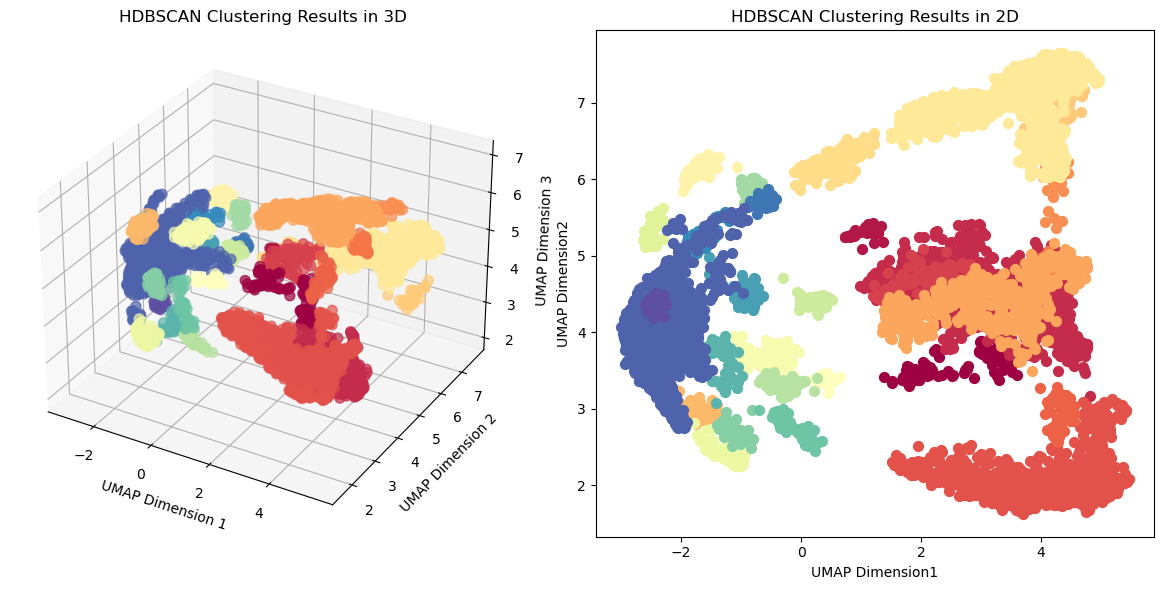

In [43]:
min_samples      = 30 # The amount of neighbors a point needs to be a 'core point'. Set higher to get less clusters but too high will cluster everything together
min_cluster_size = 30 # The minimum amount needed to form a cluster. Set this higher to get less clusters but too high will cluster everything together

clusterer = cluster_and_visualize_umap(umap_result, min_samples, min_cluster_size)

The following function will plot only the largest clusters. \
You can set the amount of largest clusters you want to plot below.

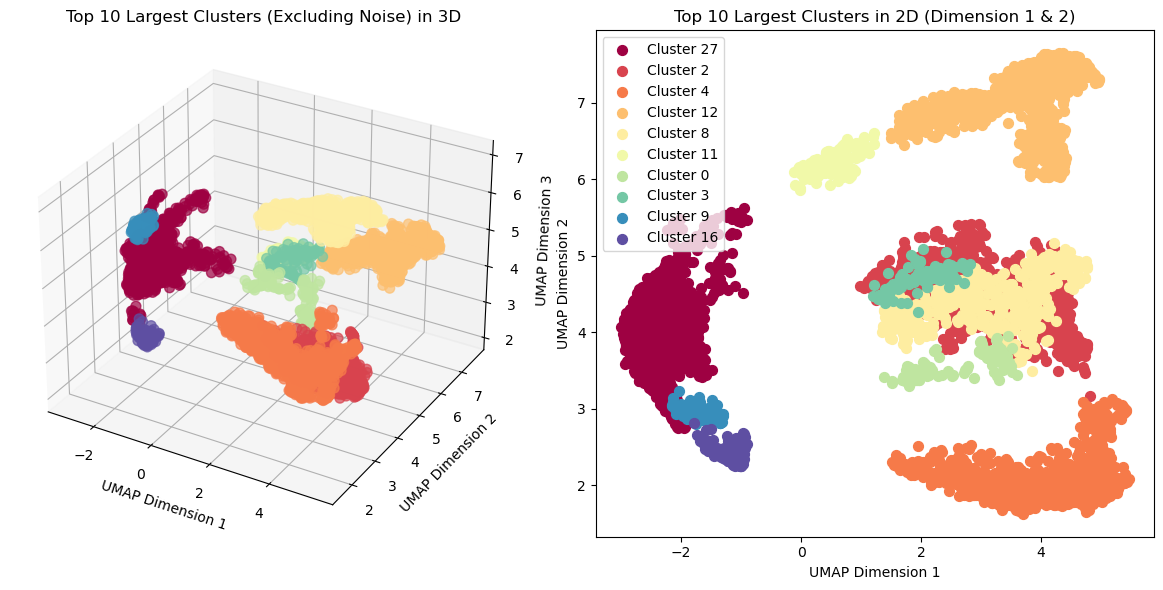

In [45]:
num_clusters_to_plot = 10 # Change this to choose how many of the largest clusters you want to show.

largest_clusters = plot_top_hdbscan_clusters(clusterer, umap_result, num_clusters_to_plot)

The following function will select the frames of each of the largest clusters from the video and save them by their cluster. \
You can set the input and output directory as desired.

In [46]:
# Add the cluster labels to our data
subset['cluster_label'] = clusterer.labels_

# Set parameters for saving frames
 # Input path, this should point to the directory containing all the mouse videos (the filtered_labeled videos).
input_video_path = "C:/Users/Kieran/Documents/Master Thesis Data/labelled_videos"
 # Output path, this is the path where you want to save the frames. Subfolders will be made for each cluster.
output_directory = "C:/Users/Kieran/Documents/Master Thesis Data/Frames"

# Saves the frames to the specified directory
save_frames_for_clusters(input_video_path, output_directory, largest_clusters, subset, datatype, n_components)

This will plot a timeline for each cluster, indicating where in the video the frames of the cluster belongs:

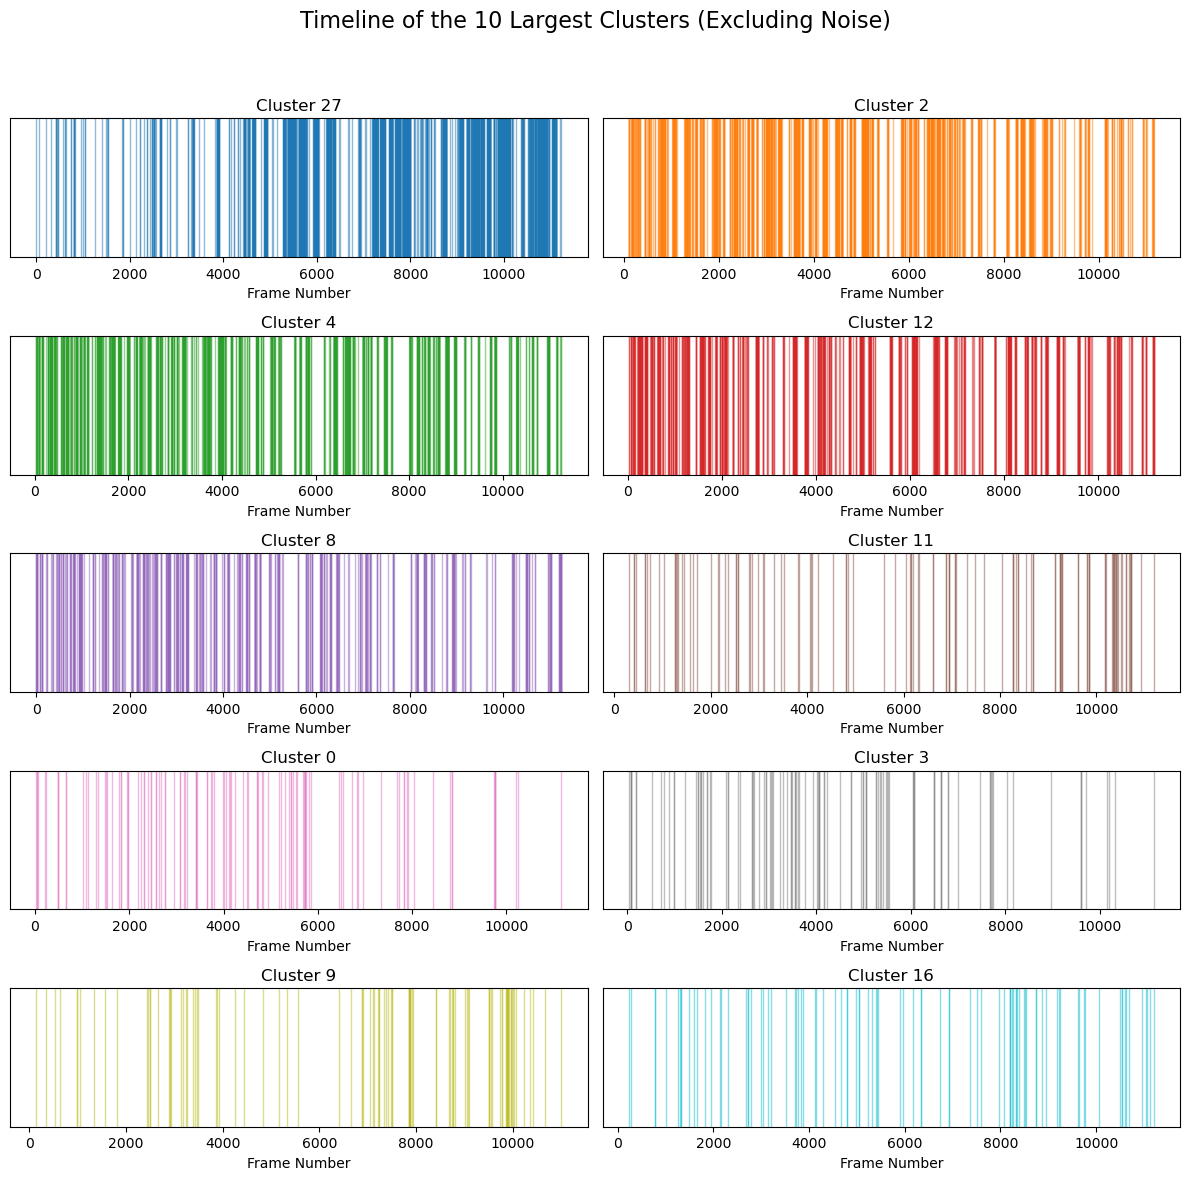

In [47]:
plot_timeline_for_largest_clusters(subset, largest_clusters)